In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import matplotlib.ticker as ticker
import pandas as pd
import helmeos
from matplotloom import Loom
from glob import glob
# from labellines import labelLine, labelLines

In [ ]:
gconst = 6.67430e-8
clight = 2.99792458e10
solar = 1.98847e33
vcgs2code = 1/clight
lencgs2code = (clight**2)/(solar*gconst)
masscgs2code = (1.0e0/solar)
rhocgs2code = (masscgs2code/lencgs2code**3)
tcgs2code = (clight**3)/(solar*gconst)
mu_0 = 1.25663706212e-6
amp2code = (mu_0*1.0e5*masscgs2code*lencgs2code)**(0.5e0)/tcgs2code
gauss2code = 1.0e-1*masscgs2code/amp2code/tcgs2code**2
energycgs2code = (1.0E0/clight**2)
me2 = 9.1093837015e-28*masscgs2code
mb2 = 1.66053906660e-24*masscgs2code
ye = 0.5e0
h_bar = (1.054571817e-27)*(lencgs2code**2*masscgs2code/tcgs2code)
amax = (me2**4)/(2.4e1*np.pi**2*h_bar**3)
bmax = (mb2*me2**3)/(3.0e0*np.pi**2*h_bar**3*ye)

def get_kappa_value(filepath):
    part_after_kappa = filepath.split('_kappa_')[-1]
    kappa_str = part_after_kappa.split('_alpha_')[0]
    return float(kappa_str)

def get_ratio_value(filepath):
    part_after_ratio = filepath.split('_AxisRatio_')[-1]
    ratio = part_after_ratio.split('_kappa_')[0]
    return float(ratio)

In [ ]:
data_paths = glob("/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_*_AxisRatio_*/")
data_paths = sorted(data_paths, key=lambda filepath: float(filepath.split('_kappa_')[-1].split('_alpha_')[0]))
data_paths

['/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_1.000_kappa_0.000E+00_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.000E+00_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.100E-04_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.300E-04_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.500E-04_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.700E-04_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.100E-03_alpha_0.000E+00/']

In [10]:
nf_list = []
for chosen in data_paths:
    working_directory = chosen+'outfile/'
    files = []
    for f in glob(working_directory+'/*.hdf5'):
        files.append(f)
    n = len(files)-1
    nf_list.append(n)
n = np.min(nf_list)

time_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    time = f['time'][0]
    time_list.append(time)
    f.close()

In [11]:
def only_plot_at_i(i):
    np.seterr(divide = 'ignore') 
    time = time_list[i]
    fig, ax = plt.subplots(nrows=3, ncols=len(data_paths), layout='constrained', figsize=(24,6), sharex={"col"})
    fig.suptitle('At $t=$'+ str('{:.3f}'.format(time/tcgs2code))+' s, units in cgs')
    
    for j, chosen in enumerate(data_paths):
        working_directory = chosen+'outfile/'
        profile_directory = chosen+'profile/'
        filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
        f = h5py.File(filename, "r")
        primitive = f['primitive'][:].T

        # Face value
        x1f = np.loadtxt(profile_directory+'/hydro_x1_fgrid.dat').T
        x3f = np.loadtxt(profile_directory+'/hydro_x3_fgrid.dat').T
        # Center value
        x1f = x1f [3:-3]*lencgs2code # Remove BC
        x1c = (x1f[1:]+x1f[:-1])/2 #mid pt
        x3f = x3f[3:-3]*lencgs2code # Remove BC
        x3c = (x3f[1:]+x3f[:-1])/2 #mid pt

        xx,zz= np.meshgrid(x1c,x3c,indexing='ij')

        xxf, zzf = np.meshgrid(x1f/lencgs2code*1e-5,x3f,indexing='ij')

        kappa = get_kappa_value(chosen)

        dens = ax[0,j].pcolormesh(xxf/lencgs2code*1e-5,zzf/lencgs2code*1e-5,np.log10(primitive[0,1:-1,1,1:-1]/rhocgs2code),cmap='inferno')
        plt.colorbar(dens,ax=ax[0,j])
        if j == 0:
            ax[0,j].set_ylabel(r'$\log \rho$')
        ax[0,j].set_title(r'$\kappa =$'+str('{:.2e}'.format(kappa)))

        pdens = ax[1,j].pcolormesh(xxf/lencgs2code*1e-5,zzf/lencgs2code*1e-5,np.log10(0.5*primitive[0,1:-1,1,1:-1]*(primitive[1,1:-1,1,1:-1]**2+primitive[3,1:-1,1,1:-1]**2)/(rhocgs2code*vcgs2code**2)),cmap='inferno')
        plt.colorbar(pdens,ax=ax[1,j])
        if j == 0:
            ax[1,j].set_ylabel(r'$\log \rho v_r^2/2$')

        rdens = ax[2,j].pcolormesh(xxf/lencgs2code*1e-5,zzf/lencgs2code*1e-5,np.log10(0.5*primitive[0,1:-1,1,1:-1]*primitive[2,1:-1,1,1:-1]**2/(rhocgs2code*vcgs2code**2)),cmap='inferno')
        plt.colorbar(rdens,ax=ax[2,j])
        if j == 0:
            ax[2,j].set_ylabel(r'$\log \rho v_\phi^2/2$')
        
def only_Bplot_at_i(i):
    np.seterr(divide = 'ignore') 
    time = time_list[i]
    fig, ax = plt.subplots(nrows=3, ncols=len(data_paths), layout='constrained', figsize=(24,6), sharex={"col"})
    fig.suptitle('At $t=$'+ str('{:.3f}'.format(time/tcgs2code))+' s, units in cgs')
    
    for j, chosen in enumerate(data_paths):
        working_directory = chosen+'outfile/'
        profile_directory = chosen+'profile/'
        filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
        f = h5py.File(filename, "r")
        bfields = f['bfield'][:].T

        kappa = get_kappa_value(chosen)

        # Face value
        x1f = np.loadtxt(profile_directory+'/hydro_x1_fgrid.dat').T
        # Center value
        x1f = x1f [3:-3]*lencgs2code # Remove BC
        x1c = (x1f[1:]+x1f[:-1])/2 #mid pt

        B2 = bfields[0,1:-1,1,1:-1]**2+bfields[1,1:-1,1,1:-1]**2+bfields[2,1:-1,1,1:-1]**2
        pB2 = bfields[0,1:-1,1,1:-1]**2+bfields[2,1:-1,1,1:-1]**2
        rB2 = bfields[1,1:-1,1,1:-1]**2

        B = ax[0,j].imshow(np.log10(np.sqrt(B2)/gauss2code).T, aspect='auto')
        plt.colorbar(B,ax=ax[0,j])
        if j == 0:
            ax[0,j].set_ylabel(r'$\log B$')
        ax[0,j].set_title(r'$\kappa =$'+str('{:.2e}'.format(kappa)))

        pB = ax[1,j].imshow(np.log10(np.sqrt(pB2)/gauss2code).T, aspect='auto')
        plt.colorbar(pB,ax=ax[1,j])
        if j == 0:
            ax[1,j].set_ylabel(r'$\log B_p$')

        rB = ax[2,j].imshow(np.log10(np.sqrt(rB2)/gauss2code).T, aspect='auto')
        plt.colorbar(rB,ax=ax[2,j])
        if j == 0:
            ax[2,j].set_ylabel(r'$\log B_t$')

def only_Blineplot_at_i(i):
    np.seterr(divide = 'ignore') 
    time = time_list[i]
    fig, ax = plt.subplots(nrows=3, ncols=1, layout='constrained', figsize=(12,6), sharex={"col"})
    fig.suptitle('At $t=$'+ str('{:.3f}'.format(time/tcgs2code))+' s, units in cgs')
    kappa_list = []

    for chosen in data_paths:
        kappa_list.append(get_kappa_value(chosen))

    for j, chosen in enumerate(data_paths):
        working_directory = chosen+'outfile/'
        profile_directory = chosen+'profile/'
        filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
        f = h5py.File(filename, "r")
        bfields = f['bfield'][:].T

        kappa = get_kappa_value(chosen)
        colors = plt.cm.viridis(np.array(kappa_list)/np.max(kappa_list))

        # Face value
        x1f = np.loadtxt(profile_directory+'/hydro_x1_fgrid.dat').T
        # Center value
        x1f = x1f [3:-3]*lencgs2code # Remove BC
        # x1c = (x1f[1:]+x1f[:-1])/2 #mid pt

        B2 = bfields[0,1:-1,1,1:-1]**2+bfields[1,1:-1,1,1:-1]**2+bfields[2,1:-1,1,1:-1]**2
        pB2 = bfields[0,1:-1,1,1:-1]**2+bfields[2,1:-1,1,1:-1]**2
        rB2 = bfields[1,1:-1,1,1:-1]**2

        mid = int((B2.shape[1]-1)/2 )

        B = ax[0].plot(x1f/lencgs2code*1e-5, np.log10(np.sqrt(B2)[:,mid]/gauss2code), label=r'$\kappa =$'+str('{:.2e}'.format(kappa)),color=colors[j])
        if j == 0:
            ax[0].set_ylabel(r'$\log B$')

        pB = ax[1].plot(x1f/lencgs2code*1e-5, np.log10(np.sqrt(pB2)[:,mid]/gauss2code), label=r'$\kappa =$'+str('{:.2e}'.format(kappa)),color=colors[j])
        if j == 0:
            ax[1].set_ylabel(r'$\log B_p$')

        rB = ax[2].plot(x1f/lencgs2code*1e-5, np.log10(np.sqrt(rB2)[:,mid]/gauss2code), label=r'$\kappa =$'+str('{:.2e}'.format(kappa)),color=colors[j])
        if j == 0:
            ax[2].set_ylabel(r'$\log B_t$')
        
        ax[0].legend(loc='upper right')

def only_plineplot_at_i(i):
    np.seterr(divide = 'ignore') 
    time = time_list[i]
    fig, ax = plt.subplots(nrows=3, ncols=1, layout='constrained', figsize=(12,6), sharex={"col"})
    fig.suptitle('At $t=$'+ str('{:.3f}'.format(time/tcgs2code))+' s, units in cgs')
    kappa_list = []

    for chosen in data_paths:
        kappa_list.append(get_kappa_value(chosen))

    for j, chosen in enumerate(data_paths):
        working_directory = chosen+'outfile/'
        profile_directory = chosen+'profile/'
        filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
        f = h5py.File(filename, "r")
        primitive = f['primitive'][:].T
        bfields = f['bfield'][:].T

        kappa = get_kappa_value(chosen)
        colors = plt.cm.viridis(np.array(kappa_list)/np.max(kappa_list))

        # Face value
        x1f = np.loadtxt(profile_directory+'/hydro_x1_fgrid.dat').T
        # Center value
        x1f = x1f [3:-3]*lencgs2code # Remove BC
        x1c = (x1f[1:]+x1f[:-1])/2 #mid pt

        mid = int((primitive[0,1:-1,1,1:-1].shape[1]-1)/2)

        dens = primitive[0,1:-1,1,1:-1][:,mid]/rhocgs2code
        pressure = primitive[4,1:-1,1,1:-1][:,mid]/energycgs2code

        Br = bfields[0,1:-1,1,1:-1]
        Bt = bfields[1,1:-1,1,1:-1]
        Bz = bfields[2,1:-1,1,1:-1]

        Br_line = (Br[:,mid] + Br[:,mid+1])/2
        Bt_line = (Bt[:,mid] + Bt[:,mid+1])/2
        Bz_line = (Bz[:,mid] + Bz[:,mid+1])/2

        Br_line_cell = (Br_line[1:] + Br_line[:-1])/2
        Bt_line_cell = (Bt_line[1:] + Bt_line[:-1])/2
        Bz_line_cell = (Bz_line[1:] + Bz_line[:-1])/2

        B2 = (Br_line_cell**2+Bt_line_cell**2+Bz_line_cell**2)/gauss2code**2

        beta = B2/(2*pressure)
        Nif = primitive[12,1:-1,1,1:-1][:,mid]

        ax[0].plot(x1c/lencgs2code*1e-5, np.log10(dens), label=r'$\kappa =$'+str('{:.2e}'.format(kappa)),color=colors[j])
        if j == 0:
            ax[0].set_ylabel(r'$\log \rho$')

        ax[1].plot(x1c/lencgs2code*1e-5, np.log10(beta), label=r'$\kappa =$'+str('{:.2e}'.format(kappa)),color=colors[j])
        if j == 0:
            ax[1].set_ylabel(r'$\log B^2/2P$')

        ax[2].plot(x1c/lencgs2code*1e-5, Nif, label=r'$\kappa =$'+str('{:.2e}'.format(kappa)),color=colors[j])
        if j == 0:
            ax[2].set_ylabel(r'$X_\text{Ni}$')
        
        ax[0].legend(loc='upper right')
    
def ftc(arr):
    temp = (arr[1:,:] + arr[:-1,:])/2
    temp2 = (temp[:,1:]+temp[:,:-1])/2
    return temp2

/tmp/ipykernel_415192/170334715.py:72: RuntimeWarning: invalid value encountered in log10
  ax[1,j].plot(np.array(time_list)/tcgs2code, np.log10(np.array(KE_list)+np.array(IntE_list)+np.array(GPE_list)+np.array(turb_list))-50, color = "black", linestyle='dashed', label = r"Total Energy")


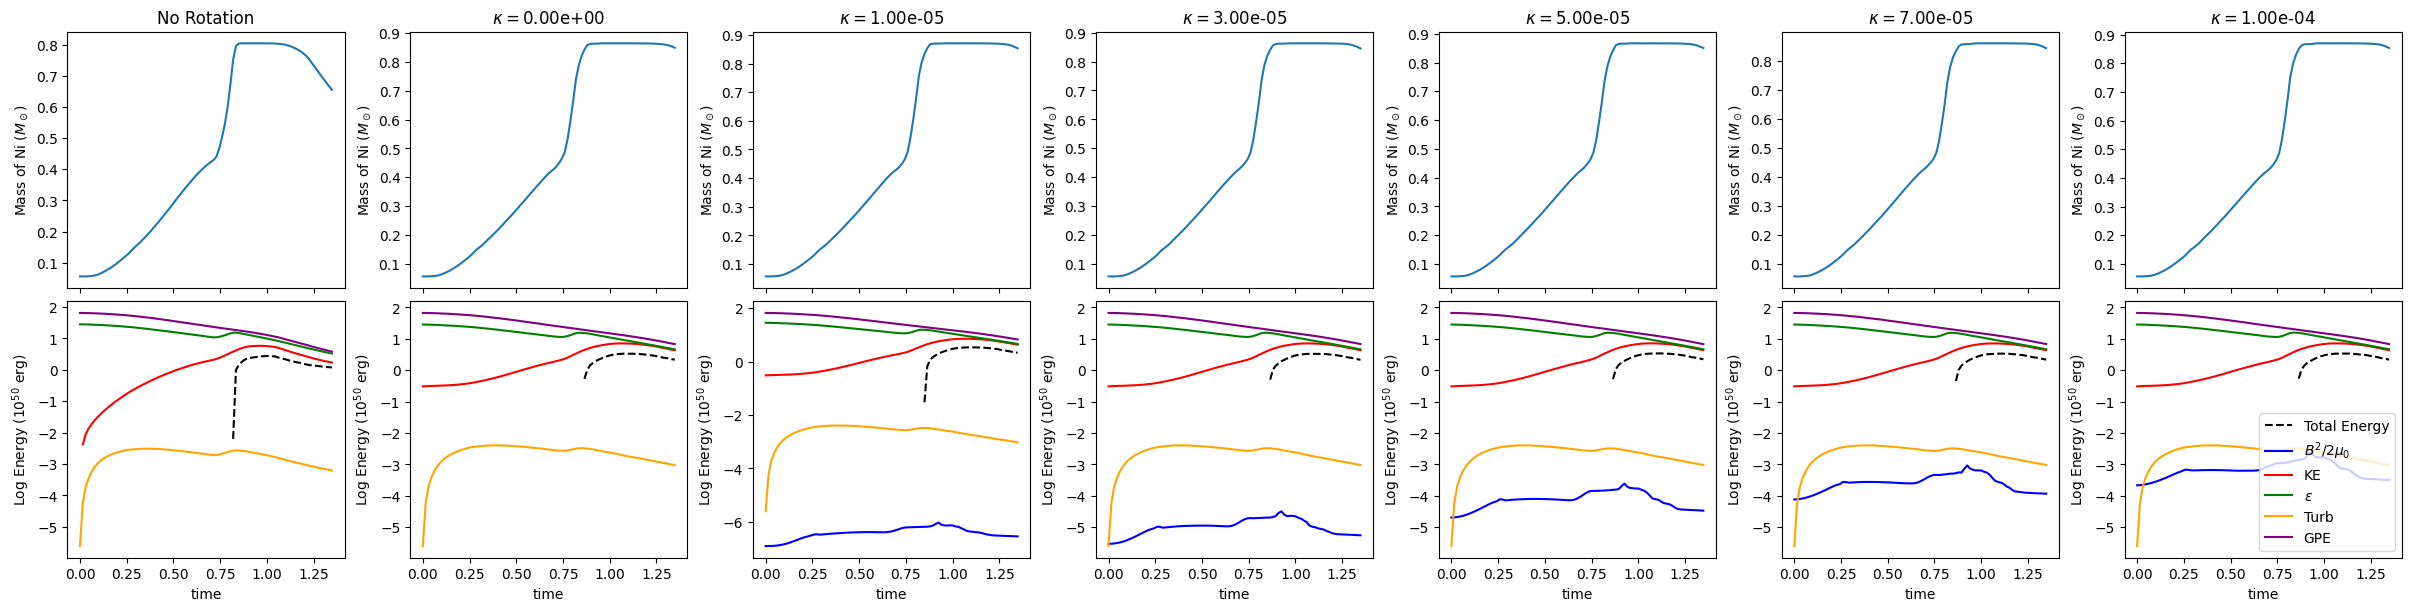

In [13]:
np.seterr(divide = 'ignore') 
fig, ax = plt.subplots(nrows=2, ncols=len(data_paths), layout='constrained', figsize=(24,6), sharex={"col"})
# fig.suptitle('At $t=$'+ str('{:.3f}'.format(time/tcgs2code))+' s, units in cgs')

for j, chosen in enumerate(data_paths):

    working_directory = chosen+'outfile/'
    filename = working_directory+"/rkiter-"+str(0)+"-nm.hdf5"
    f0 = h5py.File(filename, "r")
    vol = (f0['vol'][:].T)[:,0,:]
    f0.close()

    magen_list = []
    KE_list = []
    mass_Ni_list = []
    IntE_list = []
    turb_list = []
    GPE_list = []

    for i, time in enumerate(time_list):

        filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
        f = h5py.File(filename, "r")
        primitive = f['primitive'][:].T
        bfields = f['bfield'][:].T
        epsilon = f['epsilon'][:].T
        atmo = f['prim_a(irho)'][0]
        phi = f['phi'][:].T

        rho = primitive[0,1:-1,1,1:-1]
        v1 = primitive[1,1:-1,1,1:-1]
        v2 = primitive[2,1:-1,1,1:-1]
        v3 = primitive[3,1:-1,1,1:-1]
        Xni = primitive[12,1:-1,1,1:-1]
        turb = primitive[5,1:-1,1,1:-1]

        br = ftc(bfields[0,1:-1,1,1:-1])
        bt = ftc(bfields[1,1:-1,1,1:-1])
        bz = ftc(bfields[2,1:-1,1,1:-1])

        vsq = v1**2+v2**2+v3**2
        B2 = (br**2+bt**2+bz**2)/gauss2code**2

        epsilon = epsilon[1:-1,1,1:-1]
        phi = phi[1:-1,1,1:-1]
    
        mass_Ni = np.sum((vol*rho*Xni)[rho>atmo]) # in solar mass
        KE = np.sum((vol*rho*vsq)[rho>atmo]/2)/(masscgs2code*energycgs2code) # in cgs
        B2 = np.sum((vol/lencgs2code**3*B2)/2) # in cgs
        IntE = np.sum((vol*rho*epsilon)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs
        turbE = np.sum((vol*rho*turb)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs
        GPE = np.sum((vol*rho*phi)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs

        mass_Ni_list.append(mass_Ni)
        magen_list.append(B2)
        KE_list.append(KE)
        IntE_list.append(IntE)
        turb_list.append(turbE)
        GPE_list.append(GPE)
    
    
    kappa = get_kappa_value(chosen)
    ratio = get_ratio_value(chosen)
    if ratio != 1: 
        ax[0,j].set_title(r'$\kappa =$'+str('{:.2e}'.format(kappa)))
    if ratio == 1:
        ax[0,j].set_title("No Rotation")
    
    ax[0,j].plot(np.array(time_list)/tcgs2code, mass_Ni_list)
    ax[0,j].set_ylabel(r"Mass of Ni $(M_\odot)$")

    ax[1,j].plot(np.array(time_list)/tcgs2code, np.log10(np.array(KE_list)+np.array(IntE_list)+np.array(GPE_list)+np.array(turb_list))-50, color = "black", linestyle='dashed', label = r"Total Energy")
    ax[1,j].plot(np.array(time_list)/tcgs2code, np.log10(np.array(magen_list))-50, color = "blue", label = r"$B^2/2\mu_0$")
    ax[1,j].plot(np.array(time_list)/tcgs2code, np.log10(np.array(KE_list))-50, color = "red", label = "KE")
    ax[1,j].plot(np.array(time_list)/tcgs2code, np.log10(np.array(IntE_list))-50, color = "green", label = r"$\epsilon$")
    ax[1,j].plot(np.array(time_list)/tcgs2code, np.log10(np.array(turb_list))-50, color = "orange", label = r"Turb")
    ax[1,j].plot(np.array(time_list)/tcgs2code, np.log10(np.abs(np.array(GPE_list)))-50, color = "purple", label = r"GPE")
    ax[1,j].set_ylabel(r"Log Energy ($10^{50}$ erg)")

    ax[1,j].set_xlabel(r"time")
if j == len(data_paths) - 1 :
    ax[1,j].legend(loc='lower right')
plt.savefig('kappa_time')